In [6]:
"""
12.11.19
This is a plotting routine to create detailed source-receiver maps for publications, talks
"""

'\n12.11.19\nThis is a plotting routine to create detailed source-receiver maps for publications, talks\n'

In [7]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from mpl_toolkits.basemap import Basemap
from obspy import read_inventory, read_events

from pyatoa.utils.tools.calculate import normalize_a_to_b, myround
from pyatoa.utils.visuals.map_tools import event_beachball, interpolate_and_contour, place_scalebar
from pyatoa.utils.visuals.map_plugins import plot_geonet_active_faults

mpl.rcParams['axes.linewidth'] = 2.


In [8]:
def initiate_basemap(map_corners, scalebar=True, **kwargs):
    """
    set up the basemap object in the same way each time

    :type map_corners: dict of floats
    :param map_corners: {lat_min,lat_max,lon_min,lon_max}
    :type scalebar: bool
    :param scalebar: add a scalebar to the map
    :rtype m: Basemap
    :return m: basemap object
    """
    continent_color = kwargs.get("contininent_color", "w")
    lake_color = kwargs.get("lake_color", "w")
    coastline_zorder = kwargs.get("coastline_zorder", 5)
    coastline_linewidth = kwargs.get("coastline_linewidth", 2.0)
    fill_color = kwargs.get("fill_color", "w")
    scalebar_location = kwargs.get("scalebar_location", "lower-right")

    # Initiate map and draw in style
    m = Basemap(projection='stere', resolution='h', rsphere=6371200,
                lat_0=(map_corners['lat_min'] + map_corners['lat_max'])/2,
                lon_0=(map_corners['lon_min'] + map_corners['lon_max'])/2,
                llcrnrlat=map_corners['lat_min'],
                urcrnrlat=map_corners['lat_max'],
                llcrnrlon=map_corners['lon_min'],
                urcrnrlon=map_corners['lon_max'],
                )
    m.drawcoastlines(linewidth=coastline_linewidth, zorder=coastline_zorder)
    m.fillcontinents(color=continent_color, lake_color=lake_color)
    m.drawmapboundary(fill_color=fill_color)
    m.drawparallels(np.arange(int(map_corners['lat_min']),
                              int(map_corners['lat_max']), 1),
                    labels=[1, 0, 0, 0], linewidth=0, fontsize=13,
                    rotation=45)
    m.drawmeridians(np.arange(int(map_corners['lon_min']),
                              int(map_corners['lon_max'])+1, 1),
                    labels=[0, 0, 0, 1], linewidth=0, fontsize=13,
                    rotation=45)

    if scalebar:
        place_scalebar(m, map_corners, loc=scalebar_location)

    return m

In [9]:
def get_stations(m, station_info, sta_ignore=[], net_ignore=[], **kwargs):
    """
    Get station info from a Specfem STATION file
    
    :type m: basemap
    :param m: map for converting coordinates
    :type station_info: np.array
    :param station_info: array from reading in the station file using numpy
    """
    x, y, separate = [], [], []
    for station in station_info:
        sta, net, lat, lon = station
        if net in net_ignore:
            continue
        if sta in sta_ignore:
            continue
        name = f"{net}.{sta}"
        xy = m(float(lon), float(lat))
        x.append(xy[0])
        y.append(xy[1])
        if net == "NZ":
            separate.append(1)
        else:
            separate.append(0) 

    return x, y, separate


def plot_stations(x, y, separate=None, **kwargs):
    """
    Plot station information on the map with allowable colors
    
    :type x: list
    :param x: x coordinates 
    :type y: list
    :param y: y coordinates
    :type colors: list
    :param colors: color to plot each station
    """
    markersize = kwargs.get("markersize", 100)
    zorder = kwargs.get("zorder", 100)
    
    if separate:
        for i, sep in enumerate(separate):
            # GeoNet
            if sep:
               # "mediumspringgreen"
                m.scatter(x[i], y[i], marker='d', s=markersize, edgecolors='k', 
                          c="mediumspringgreen", linestyle='-', linewidth=2., zorder=zorder)
            else:
                m.scatter(x[i], y[i], marker='d', s=markersize, edgecolors='k', hatch="|||",
                          c="mediumspringgreen", linestyle='-', linewidth=2., zorder=zorder)
    else:
        m.scatter(x[i], y[i], marker='v', s=markersize, edgecolors='k', 
                  c="w", linestyle='-', linewidth=2., zorder=zorder)

In [10]:
def plot_cities(m, names=False, **kwargs):
    """
    Plot major population centers
    
    :type m: basemap
    :param m: map to plot cities on
    :type names: bool
    :param names: annotate names on map
    """
    markersize = kwargs.get("markersize", 80)
    color = kwargs.get("color", "w")
    fontsize = kwargs.get("fontsize", 12)
    zorder = kwargs.get("zorder", 100)

    cities = [(-41.28664, 174.77557, "Wellington"),
              (-39.6381, 176.84918, "Hastings"),
              (-42.416665, 173.6833306, "Kaikoura")]

    for city in cities:
        xy = m(city[1], city[0])
        m.scatter(xy[0], xy[1], marker='o', s=markersize, edgecolor='k', 
                  c=color, linewidth=2, zorder=zorder)
        if names:
            plt.text(x + 0.02 * (m.xmax - m.xmin), y + 0.02 * (m.ymax - m.ymin),
                     s = city[2], fontsize=fontsize, zorder=zorder,
                     fontweight='roman',
                     bbox=dict(facecolor='w', fill=True, edgecolor='w',
                               alpha=0.75, boxstyle='round')
                     )

In [11]:
def get_beachballs(cat, cmap, norm_a=1.4E4, norm_b=2.3E4):
    """
    Get event information from the moment tensor attributes of the
    
    :type cat: obspy.Catalog
    :param cat: catalog with events that contain moment tensor attributes
    :type cmap: matplotlib.colors.ListedColorMap
    :param cmap: chosen colormap for event depths
    :rtype depths: list
    :return depths: depths in km from events
    :rtype mags: list
    :return mags: magnitudes of events
    :rtype normalize: matplotlib.colors.BoundaryNorm
    :retrun normalize: normalized discrete colormap for colorbar
    """
    depths, mags = [], []
    for event in cat:
        depths.append(event.preferred_origin().depth * 1E-3)
        mags.append(event.preferred_magnitude().mag)

    # normalize the colormap, create a discrete colorbar
    max_depth = myround(max(depths), 5, 'up')
    normalize = mpl.colors.BoundaryNorm(range(0, max_depth, 5), cmap.N)

    # normalize the magnitudes
    mags = normalize_a_to_b(mags, a=norm_a, b=norm_b)

    return depths, mags, normalize
    
    
def plot_beachballs(m, cat, depths, mags, cmap, normalize, **kwargs):
    """
    Plot moment tensors as beachballs, color by depth if requested

    :type m: basemap
    :param m: map to plot beacbhalls on
    :type cat: obspy.Catalog
    :param cat: catalog with events
    :type depths: list
    :param depths: depths in km of events
    :type mags: list
    :param mags: magnitudes of events
    :type cmap: matplotlib.colors.ListedColorMap
    :param cmap: chosen colormap for event depths
    :type normalize: matplotlib.colors.BoundaryNorm
    :param normalize: normalized discrete colormap for colorbar
    """
    cbar_shrink = kwargs.get("cbar_shrink", 0.35)
    
    for i, event in enumerate(cat):
        event_beachball(m, event, fm_type="strike_dip_rake",
                        facecolor=cmap(normalize(depths[i])),
                        width=mags[i],
                        **kwargs
                        )

    # create a colormap for the colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalize)
    sm.set_array([])
    cbar = plt.colorbar(sm, extend='max', shrink=cbar_shrink, aspect=10)
    cbar.set_label("depth (km)", rotation=270, labelpad=15, fontsize=15)
    cbar.ax.invert_yaxis()
    cbar.ax.tick_params(axis='y', direction='in', length=0, width=1.75)

In [12]:
def interpolate_interface(m, plate):
    """
    Interpolate an interface for contour plot
    
    :type m: basemap
    :param m: map convert coordinates
    :type plate: np.array
    :param plate: info read in from plate interface npy file
    :rtype xi, yi, zi: np.array
    :return xi, yi, zi: gridded data for use in contour
    """
    lats = plate[:, 0]
    lons = plate[:, 1]
    depths = plate[:, 2]
    depths = [-1 * _ for _ in depths]
    
    x, y = m(lons, lats)
    xi = np.linspace(min(x), max(x), 1000)
    yi = np.linspace(min(y), max(y), 1000)
    
    xi, yi = np.meshgrid(xi, yi)
    zi = griddata((x, y), depths, (xi, yi))
    
    return xi, yi, zi


def plot_interface_contour(m, xi, yi, zi, **kwargs):
    """
    Plot the plate interface as contours, inline labels for depths
    
    :type m: basemap
    :param m: map convert coordinates
    :type plate: np.array
    :param plate: info read in from plate interface npy file
    :type xi, yi, zi: np.array
    :param xi, yi, zi: gridded data for use in contour
    """
    zorder = kwargs.get("zorder", 100)
    levels = kwargs.get("levels", [0,5,10,15,25,50,100,200,300])
    color = kwargs.get("color", "k")
    linestyle = kwargs.get("linestyle", "dotted")
    linewidth = kwargs.get("linewidth", 2.)
    alpha = kwargs.get("alpha", 0.5)
    fontsize = kwargs.get("fontsize", 12)
    format_ = kwargs.get("format", '%.0f km')

    cs = m.contour(xi, yi, zi, levels, vmin=0, colors=color, linestyles=linestyle, alpha=alpha, linewidth=linewidth)
    plt.clabel(cs, levels[1:], fontsize=fontsize, fmt=format_)

In [13]:
# User Parameters
# Lat_min: 20 km south of KHZ (173.359, -42.416); Lat_max: 20 km north of KAZ (175.1612, -37.1041)
# Lon_min: 20 km west of NNZ (173.3795, -41.2171); Lon_max: 20 km east of MXZ (179.3066, -37.5623)
map_corners={'lat_min': -42.6, 'lat_max': -36.925,
             'lon_min': 173.14, 'lon_max': 178.5}

# Read in associated file paths
cat = read_events("./charlie_trial.xml")  # Based on the events used in your inversion
stations = np.loadtxt("./TRIALS_STATIONS_78", usecols=(0,1,2,3), dtype=str)  # in Specfem3D format
plate = np.load("./plate_interface.npy")  # Created from Charle's Williams plate interface model

/Users/chowbr/miniconda3/envs/tomo/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/Users/chowbr/miniconda3/envs/tomo/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


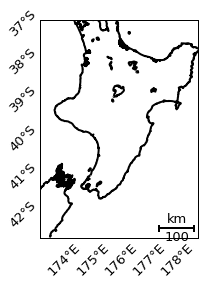

In [14]:
# Plotting kwargs that need to be instantiated before data collection
figsize = (10, 12)
dpi = 100
coastline_linewidth = 2.25
continent_color= "w"
lake_color = "w"
fill_color = "w"
scalebar_location = "lower-right"

# initiate a basemap with the correct corners to use for coordinate transforms
m = initiate_basemap(map_corners)

In [29]:
# Get station information for plotting
net_ignore = ["X1", "X2", "GH"]
sta_ignore = ["MRWZ"]
sta_x, sta_y, sta_colors = get_stations(m, stations, net_ignore=net_ignore, sta_ignore=sta_ignore)

In [16]:
# Get beachball information for plotting
beachball_colormap = plt.cm.plasma
beachball_norms = [1.4E4, 2.3E4]

depths, mags, normalize = get_beachballs(cat, cmap=beachball_colormap, norm_a=beachball_norms[0],
                                         norm_b=beachball_norms[1])

In [17]:
# Interpolate the interface on a regular grid (takes a little while)
xi, yi, zi = interpolate_interface(m, plate)

In [18]:
# Plotting Kwargs to control element sizes and colors 
station_markersize = 150
station_zorder = 100

beachball_linewidths = 1.6
beachball_zorder = station_zorder - 1
cbar_shrink = 0.2

city_zorder = station_zorder + 1
city_markersize = 100
city_fontsize = 12
city_names = False
city_color = "burlywood"

contour_zorder = station_zorder - 2
contour_levels = [0,5,10,15,25,50,100,200,300]
contour_color = "k"
contour_linestyle = "dotted"
contour_linewidth = 3.
contour_alpha = 0.5
clabel_fontsize = 13
clabel_format = '%.0f km'

fault_linestyle = "-."
fault_linewidth = 1
fault_color = 'k'
fault_zorder = station_zorder - 3
fault_alpha = 0.25

/Users/chowbr/miniconda3/envs/tomo/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/Users/chowbr/miniconda3/envs/tomo/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/Users/chowbr/miniconda3/envs/tomo/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


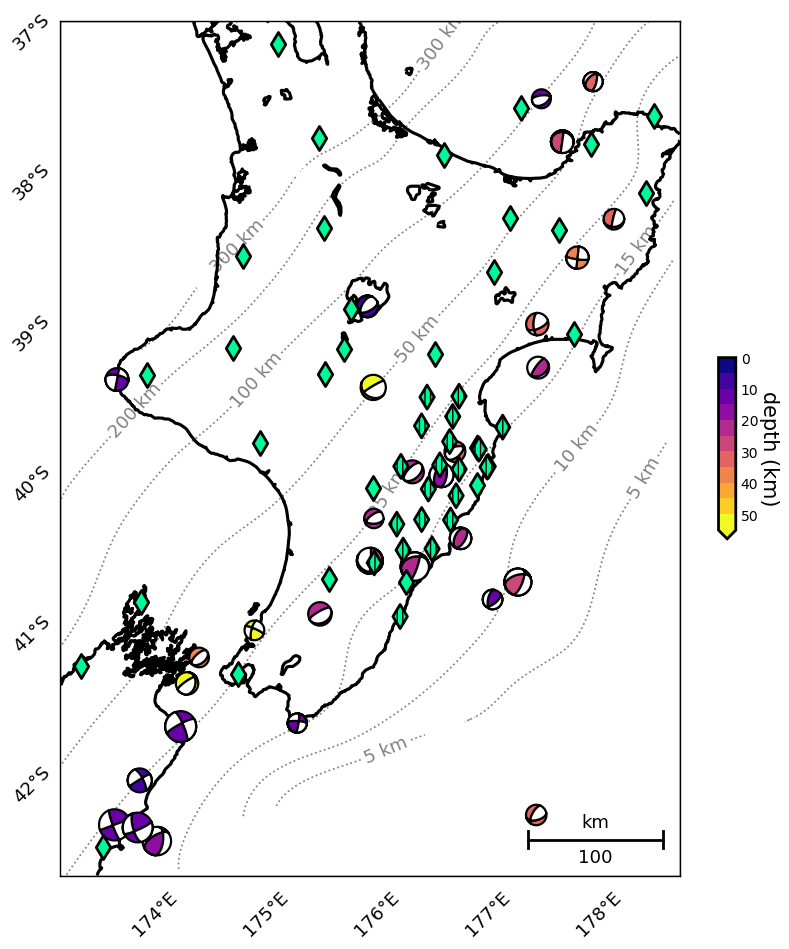

In [30]:
# This cell creates a general source receiver map
f = plt.figure(figsize=figsize, dpi=dpi)
ax = f.add_subplot(111)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)

m = initiate_basemap(map_corners, continent_color=continent_color,
                     lake_color=lake_color, fill_color=fill_color,
                     coastline_linewidth=coastline_linewidth, scalebar=True,
                     scalebar_location=scalebar_location
                     )

# Plot each of the individual components
plot_stations(sta_x, sta_y, sta_colors, net_ignore=net_ignore, markersize=station_markersize, zorder=station_zorder)

plot_beachballs(m, cat, depths, mags, beachball_colormap, normalize, zorder=beachball_zorder, 
                linewidth=beachball_linewidths, cbar_shrink=cbar_shrink)

# plot_cities(m, zorder=city_zorder, markersize=city_markersize, fontsize=city_fontsize, names=city_names,
#             color=city_color)

plot_interface_contour(m, xi, yi, zi, zorder=contour_zorder, levels=contour_levels, color=contour_color, 
                       linestyle=contour_linestyle, linewidth=contour_linewidth, alpha=contour_alpha, 
                       fontsize=clabel_fontsize, format_=clabel_format)

# plot_geonet_active_faults(m, linestyle=fault_linestyle, linewidth=fault_linewidth, color=fault_color, 
#                           alpha=fault_alpha)  # this takes a while

plt.savefig("srcrcv_map.png", dpi=dpi, figsize=figsize)

In [20]:
isinstance(5, int)

True

In [21]:
type(5)

int

In [22]:
test = {"a":
       5}

In [23]:
"a" in test

True